# Analysis to pick the best token length for ECOLI cohort

## Read bed files containing tokens

In [2]:
import os
import pandas as pd
from pathlib import Path


bedDir = Path(os.environ['GENOMICS_DATA_BASE'], 'genome_nlp_tokens', 'bed_files', 'ECOLI')

bedDfList = []
for bedFile in os.listdir(bedDir):
    tubeid = bedFile.split('.')[0].split('_')[0]
    tokensDf = pd.read_csv(Path(bedDir, bedFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score'])
    tokensDf['tube_id'] = tubeid
    bedDfList.append(tokensDf)

bedDf = pd.concat(bedDfList, ignore_index=True)
bedDf

,contig_id,start_position,end_position,tokens,score,tube_id
0,1,1,3,GAA,0.024555,AH21B049
1,1,4,12,AAACCCCGG,0.019281,AH21B049
2,1,13,17,TCAAT,0.042749,AH21B049
3,1,18,22,AAGGC,0.058446,AH21B049
4,1,23,27,CGGGG,-0.002272,AH21B049
...,...,...,...,...,...,...
247349726,5,259913,259920,GCTACCCG,0.012245,ALF22C077
247349727,5,259921,259928,TTGGTGTG,0.000125,ALF22C077
247349728,5,259929,259938,CCTGTTCCGT,-0.000540,ALF22C077
247349729,5,259939,259942,GGCC,0.024973,ALF22C077


## Calculate token lengths

In [3]:
bedDf['token_length'] = bedDf.tokens.apply(lambda x: len(x))
bedDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length
0,1,1,3,GAA,0.024555,AH21B049,3
1,1,4,12,AAACCCCGG,0.019281,AH21B049,9
2,1,13,17,TCAAT,0.042749,AH21B049,5
3,1,18,22,AAGGC,0.058446,AH21B049,5
4,1,23,27,CGGGG,-0.002272,AH21B049,5
...,...,...,...,...,...,...,...
247349726,5,259913,259920,GCTACCCG,0.012245,ALF22C077,8
247349727,5,259921,259928,TTGGTGTG,0.000125,ALF22C077,8
247349728,5,259929,259938,CCTGTTCCGT,-0.000540,ALF22C077,10
247349729,5,259939,259942,GGCC,0.024973,ALF22C077,4


## Generate with and without signature files for different token lengths

In [44]:
import os

from pathlib import Path


for tokenLength in range(5, 13):
    print('tokenLength: ', tokenLength)
    tokensDf = bedDf[bedDf.token_length > tokenLength]
    highscoreTokens = list(tokensDf.sort_values(by=['score'], ascending=False).tokens.unique()[:10])
    groupedDf = tokensDf[tokensDf.tokens.isin(highscoreTokens)].groupby(by=['tube_id'])['tokens'].nunique().reset_index().rename(columns={'tokens': 'unique_token_count'})
    uniqueTokenCountCountsDf = groupedDf.unique_token_count.value_counts().reset_index().sort_values(by=['unique_token_count'], ascending=False)
    uniqueTokenCountCountsDf['cumulative_count'] = uniqueTokenCountCountsDf['count'].cumsum()
    uniqueTokenCountCountsDf['cumulative_proportion'] = uniqueTokenCountCountsDf['cumulative_count']/uniqueTokenCountCountsDf['count'].sum()
    uniqueTokenCountCountsDf = uniqueTokenCountCountsDf.sort_values(by=['cumulative_proportion'])
    print('uniqueTokenCountCountsDf: ', uniqueTokenCountCountsDf)
    countCutoff = int(uniqueTokenCountCountsDf[(uniqueTokenCountCountsDf.cumulative_proportion > 0.2)][:1].unique_token_count.values[0])
    print('countCutoff: ', countCutoff)
    withoutSignatureDf = groupedDf[groupedDf.unique_token_count < countCutoff]
    print('without signature: ', withoutSignatureDf.shape[0])
    withSignatureDf = groupedDf[groupedDf.unique_token_count >= countCutoff]
    print('with signature: ', withSignatureDf.shape[0])
    withoutSignatureDf.tube_id.to_csv(Path(os.environ['GENOMICS_DATA_BASE'], 'survival_analysis', 'ECOLI', 'tl_' + str(tokenLength) + '_wos_tubeids.txt'), index=False)
    withSignatureDf.tube_id.to_csv(Path(os.environ['GENOMICS_DATA_BASE'], 'survival_analysis', 'ECOLI', 'tl_' + str(tokenLength) + '_ws_tubeids.txt'), index=False)

tokenLength:  5
uniqueTokenCountCountsDf:     unique_token_count  count  cumulative_count  cumulative_proportion
0                  10    769               769               0.893148
1                   9     89               858               0.996516
2                   8      3               861               1.000000
countCutoff:  10
without signature:  92
with signature:  769
tokenLength:  6
uniqueTokenCountCountsDf:     unique_token_count  count  cumulative_count  cumulative_proportion
0                  10    769               769               0.893148
1                   9     89               858               0.996516
2                   8      3               861               1.000000
countCutoff:  10
without signature:  92
with signature:  769
tokenLength:  7
uniqueTokenCountCountsDf:     unique_token_count  count  cumulative_count  cumulative_proportion
0                  10    612               612               0.710801
1                   9    197               809   

## Run log rank test

In [1]:
import os

from pathlib import Path

import pandas as pd

from lifelines.utils import datetimes_to_durations

from lifelines.statistics import logrank_test


rows = []

journeysDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'data', 'full_cohort', 'journry_times.csv'))
mappingDf = pd.read_csv(Path(os.environ['GENOMICS_DATA_BASE'], 'patient_tube_id_mapping_full.tsv'), sep='\t')[['tube_code', 'PATIENT_ID']].drop_duplicates()
mergedDf = journeysDf.merge(
    mappingDf,
    how='inner',
    left_on='person_id',
    right_on='PATIENT_ID'
).drop(columns=['PATIENT_ID'])


for tokenLength in range(5, 13):
    withoutSignatureTubeidsDf = pd.read_csv(Path(os.environ['GENOMICS_DATA_BASE'], 'survival_analysis', 'ECOLI', 'tl_' + str(tokenLength) + '_wos_tubeids.txt'))
    withoutSignatureDf = mergedDf.merge(
        withoutSignatureTubeidsDf,
        how='inner',
        left_on=['tube_code'],
        right_on=['tube_id']
    )
    withoutSignatureDf['cohort'] = 'Without Signature'
    withSignatureTubeidsDf = pd.read_csv(Path(os.environ['GENOMICS_DATA_BASE'], 'survival_analysis', 'ECOLI', 'tl_' + str(tokenLength) + '_ws_tubeids.txt'))
    withSignatureDf = mergedDf.merge(
        withSignatureTubeidsDf,
        how='inner',
        left_on=['tube_code'],
        right_on=['tube_id']
    )
    withSignatureDf['cohort'] = 'With Signature'
    conbinedDf = pd.concat([withoutSignatureDf, withSignatureDf], ignore_index=True)

    T, E = datetimes_to_durations(conbinedDf.admittime_adm, conbinedDf.deathtime_adm, freq='D', dayfirst=True)

    conbinedDf['T'] = T
    conbinedDf['E'] = E

    for duration in list(range(30, 150, 30)) + list(range(150, 500, 50)) + list(range(500, 1500, 100)) + list(range(1500, 2500, 200)):

        filteredDf = conbinedDf[(conbinedDf['T'] > 0) & (conbinedDf['T'] < duration)]

        results = logrank_test(
            filteredDf[(filteredDf.cohort == 'With Signature')]['T'],
            filteredDf[(filteredDf.cohort == 'Without Signature')]['T'],
            event_observed_A=filteredDf[(filteredDf.cohort == 'With Signature')]['E'],
            event_observed_B=filteredDf[(filteredDf.cohort == 'Without Signature')]['E'],
            )

        rows.append([tokenLength, duration, results.p_value])
plotDf = pd.DataFrame(rows, columns=['token length', 'journey duration', 'p value'])
plotDf

,token length,journey duration,p value
0,5,30,1.668526e-02
1,5,60,2.967342e-04
2,5,90,2.255545e-05
3,5,120,1.468774e-07
4,5,150,7.321588e-01
...,...,...,...
203,12,1500,6.412484e-01
204,12,1700,7.352074e-01
205,12,1900,2.676750e-01
206,12,2100,2.271906e-01


## Visualise p-values

### For different token lengths

<Axes: xlabel='journey duration', ylabel='p value'>

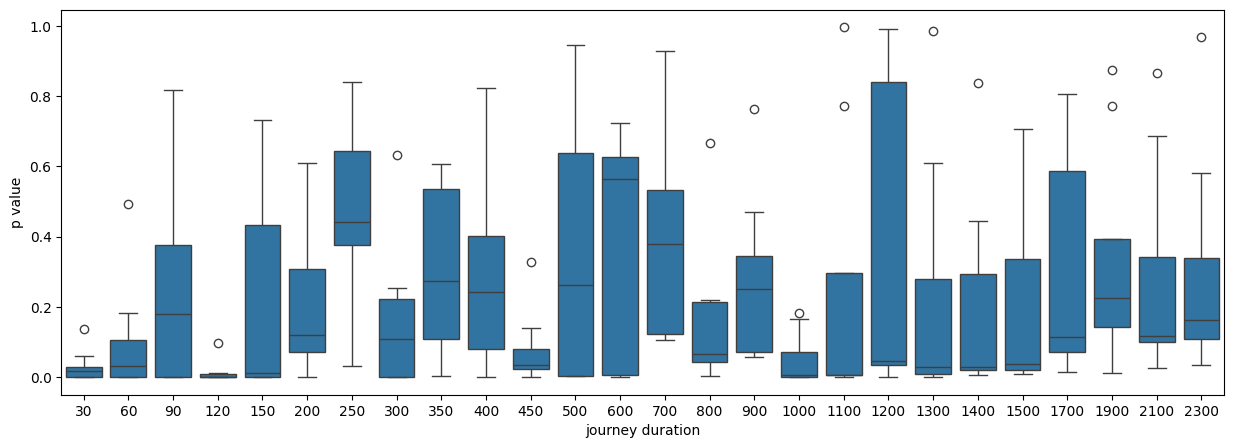

In [10]:
from matplotlib import pyplot as plt
import seaborn as sns


f, ax = plt.subplots(1, 1, figsize=(15, 5))

sns.boxplot(data=plotDf, x='journey duration', y='p value')

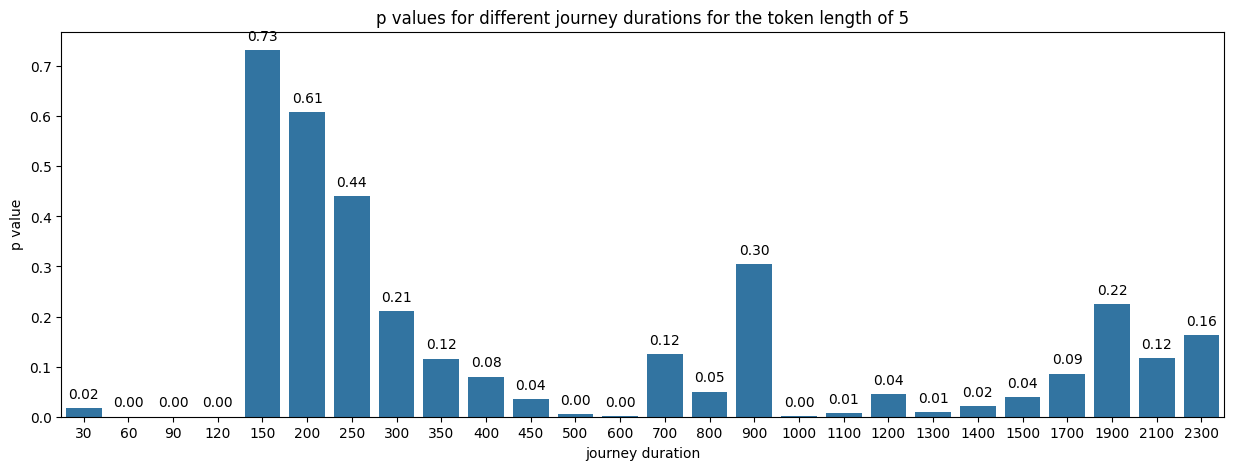

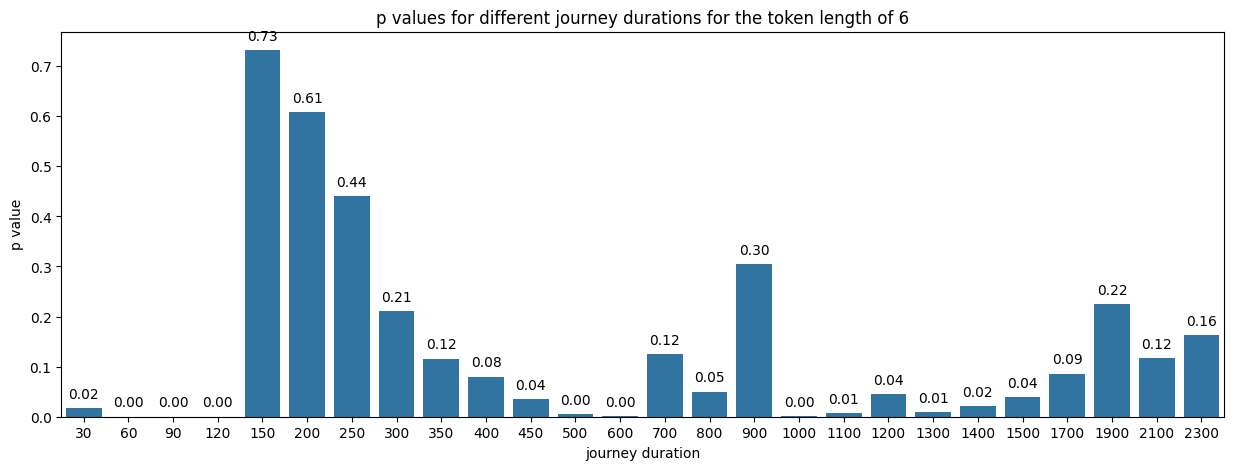

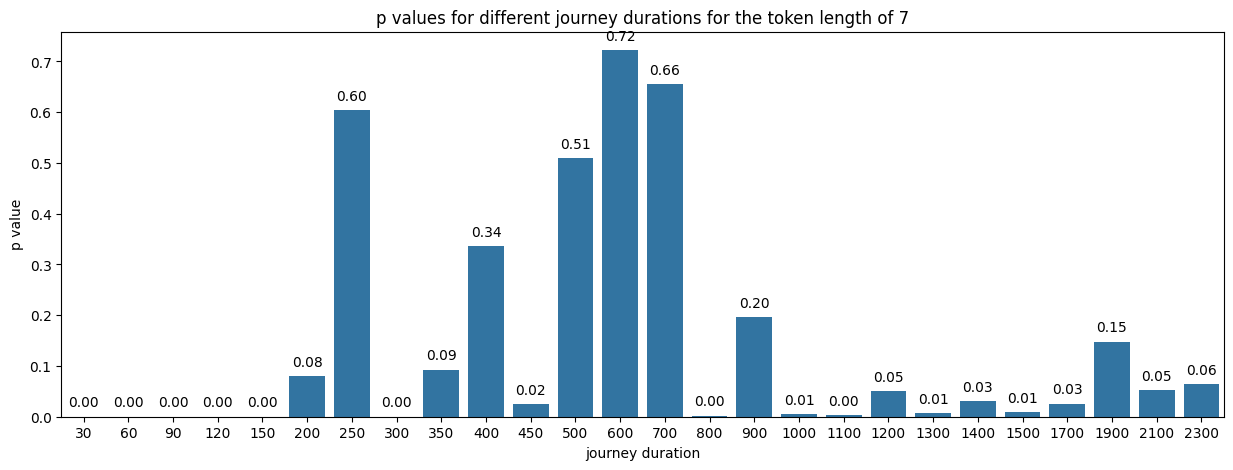

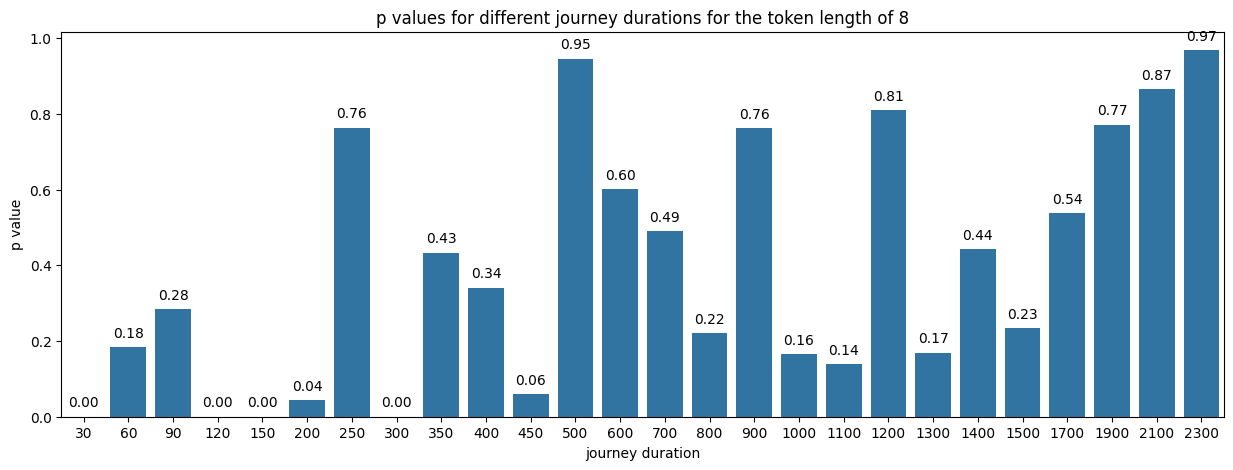

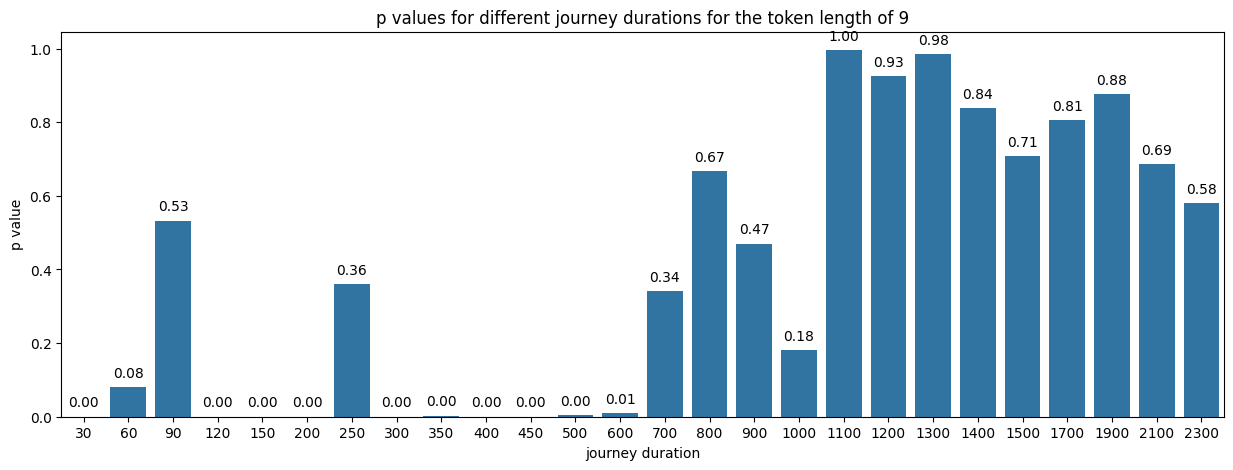

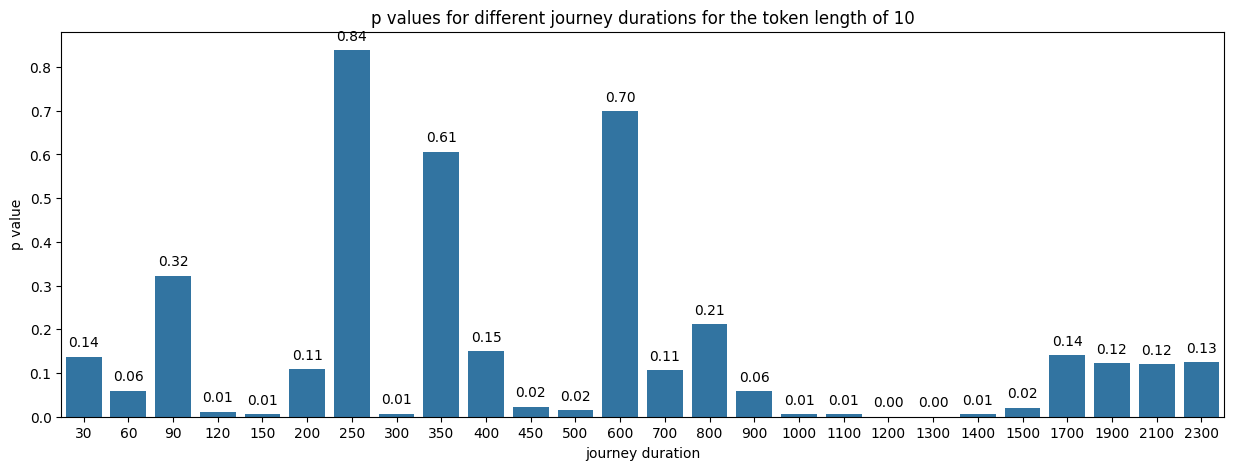

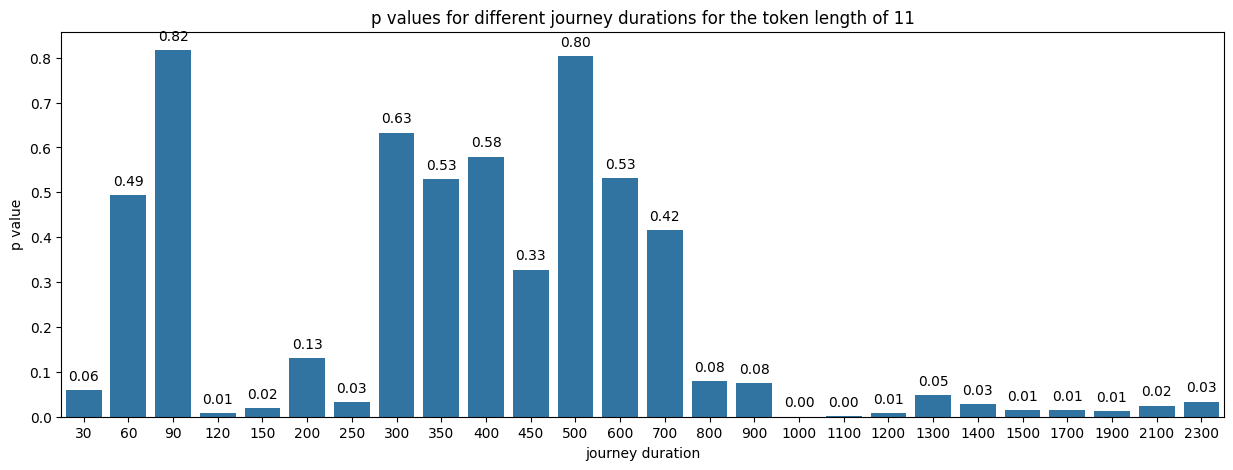

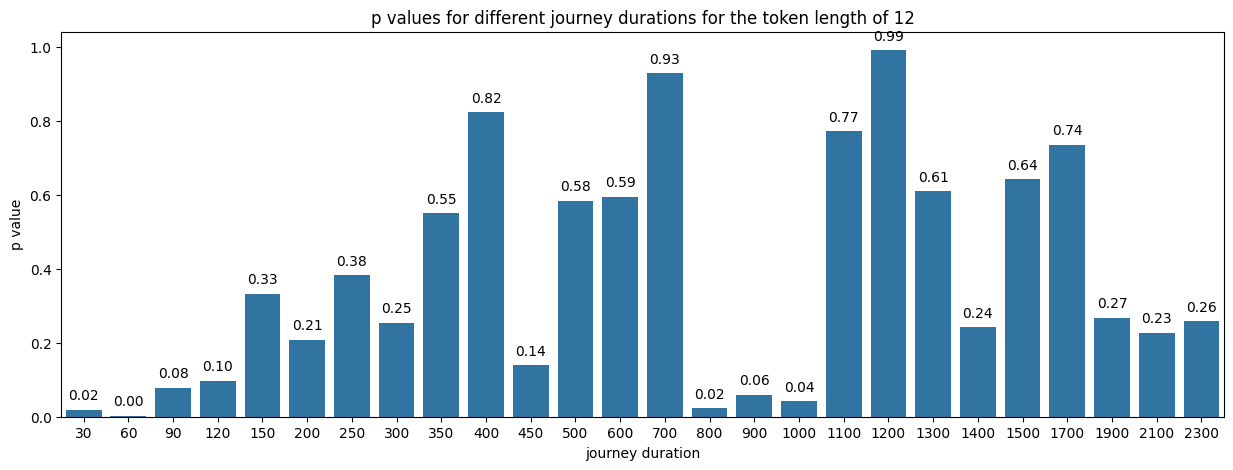

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns


for tokenLength in range(5, 13):
    f, ax = plt.subplots(1, 1, figsize=(15, 5))

    sns.barplot(plotDf[plotDf['token length'] == tokenLength], x='journey duration', y='p value',  ax=ax)

    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    
    ax.set_title('p values for different journey durations for the token length of ' + str(tokenLength))

    plt.show()

### For different journey durations

<Axes: xlabel='token length', ylabel='p value'>

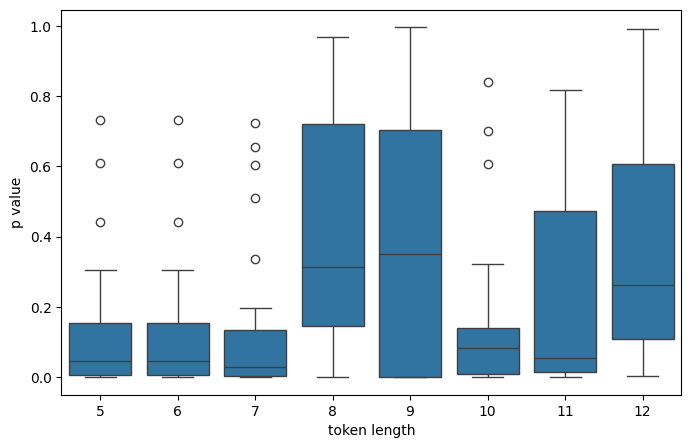

In [11]:
from matplotlib import pyplot as plt
import seaborn as sns


f, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.boxplot(data=plotDf, x='token length', y='p value')

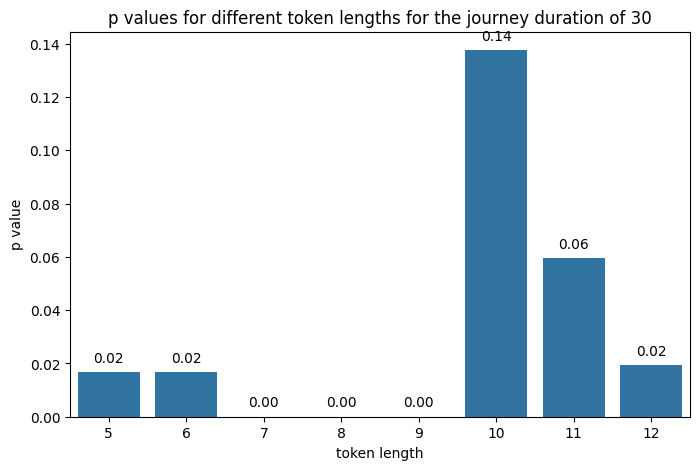

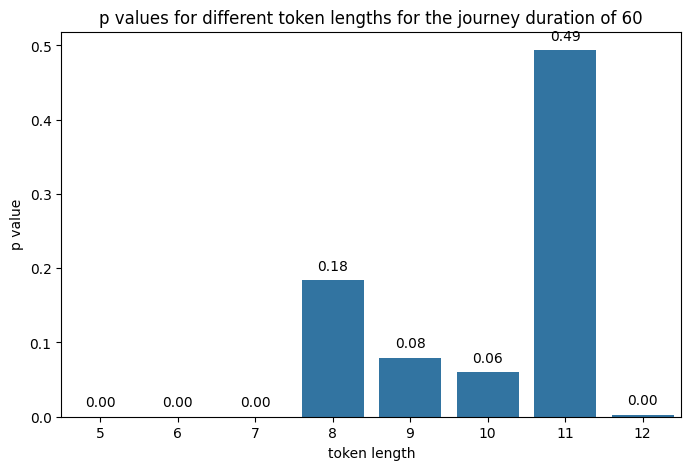

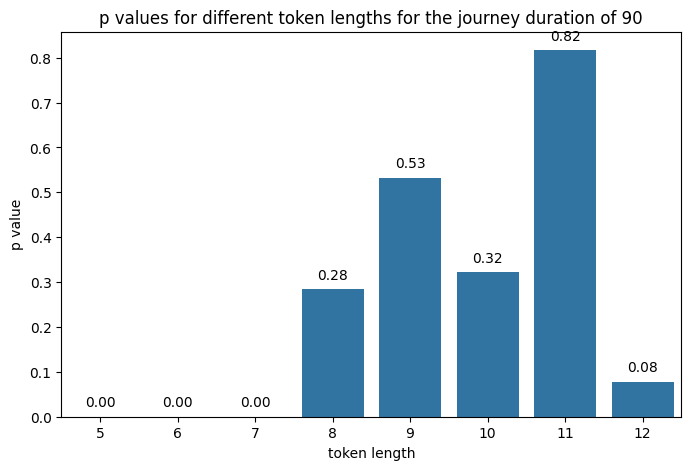

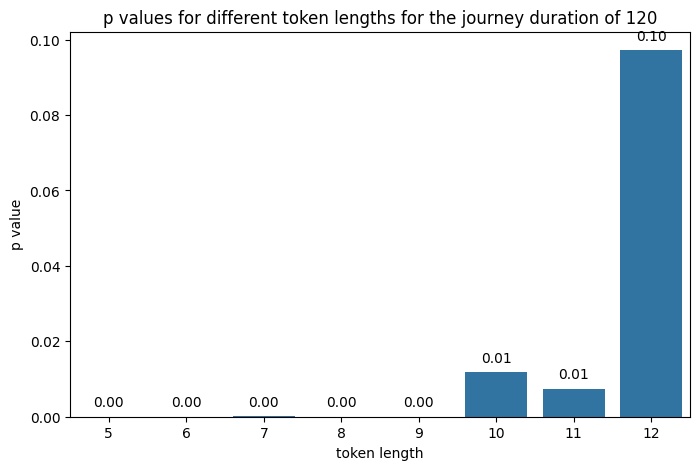

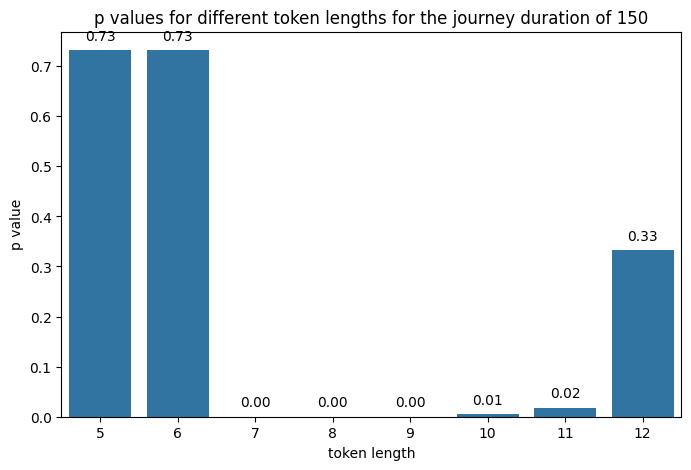

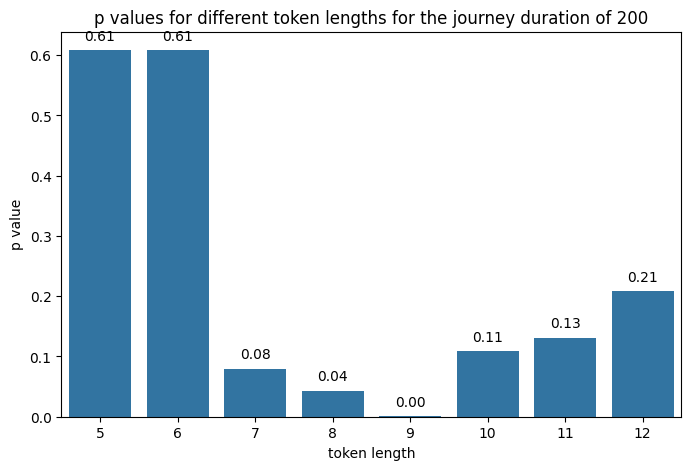

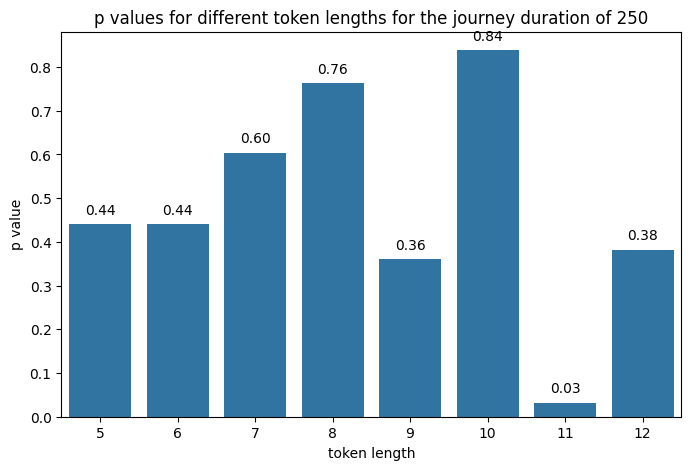

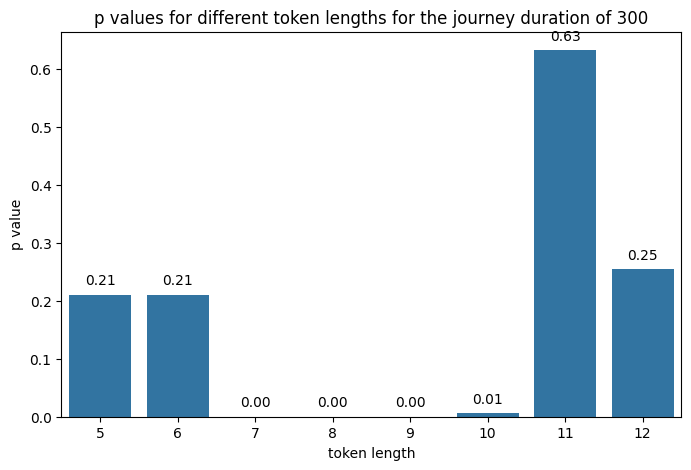

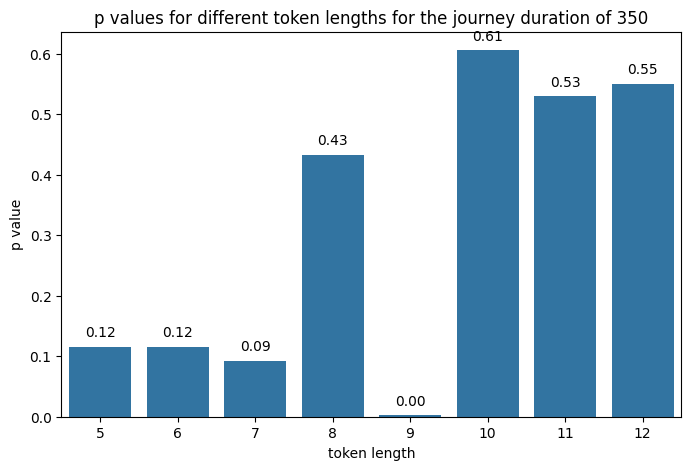

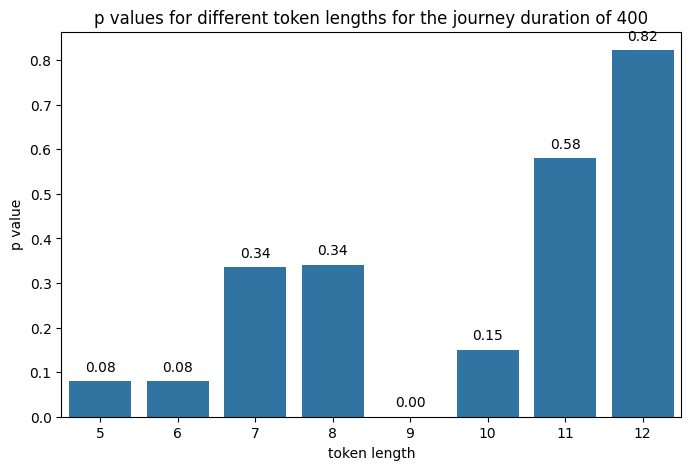

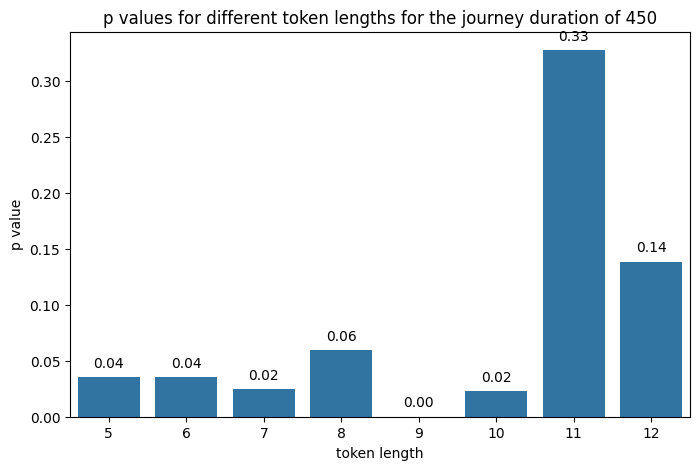

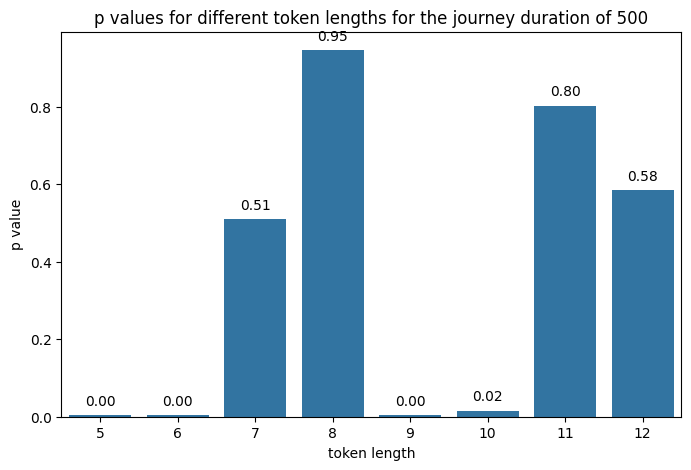

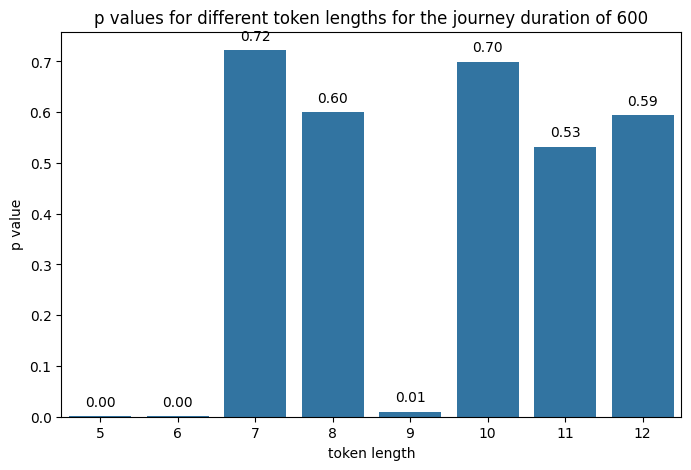

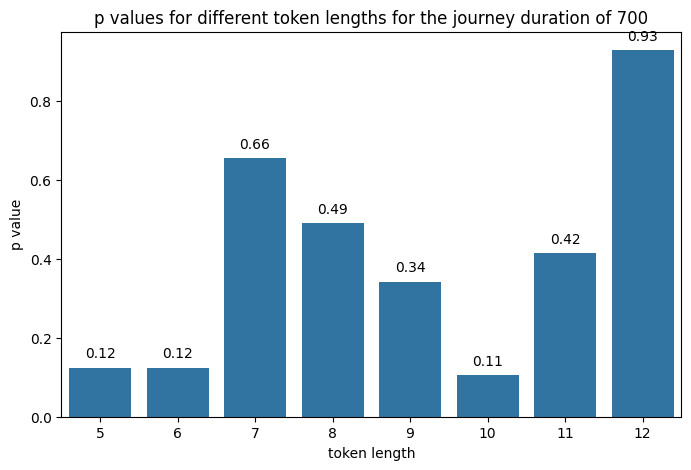

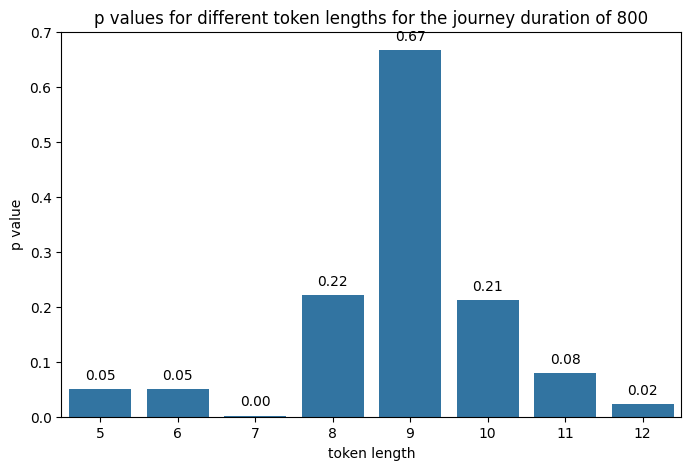

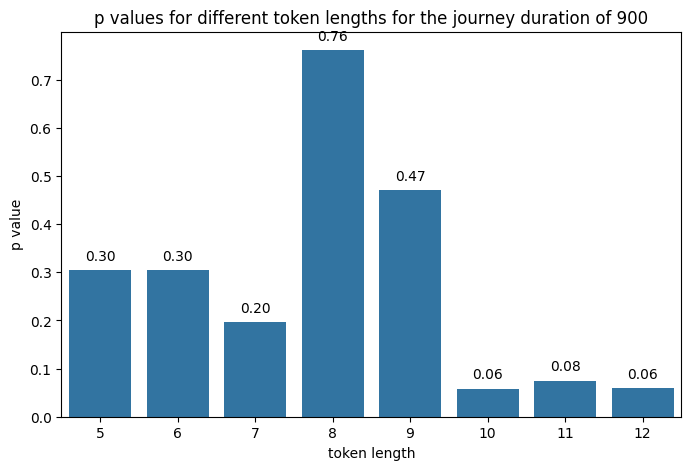

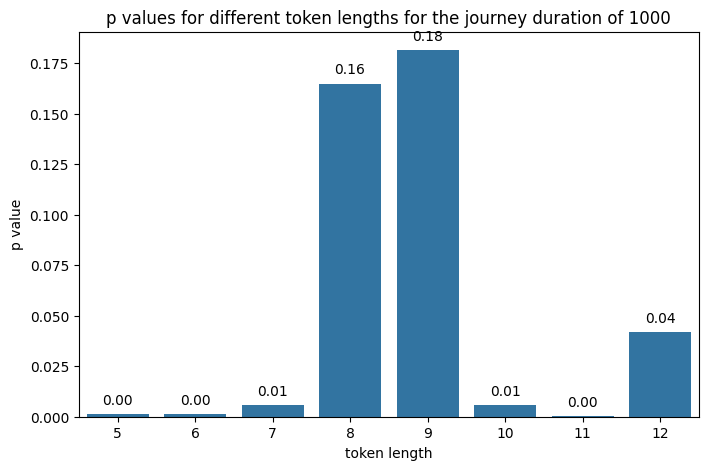

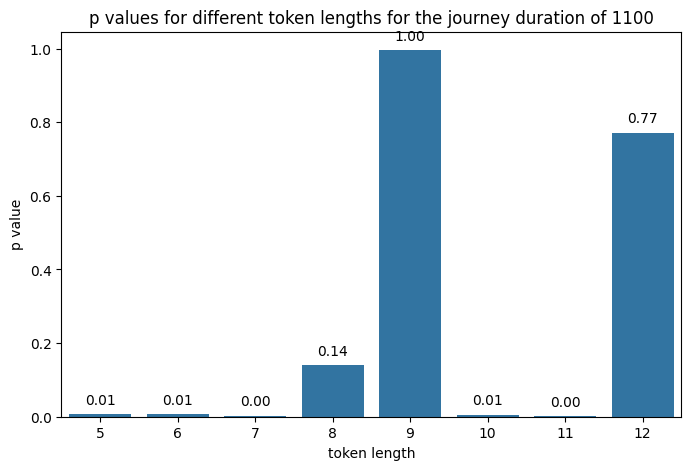

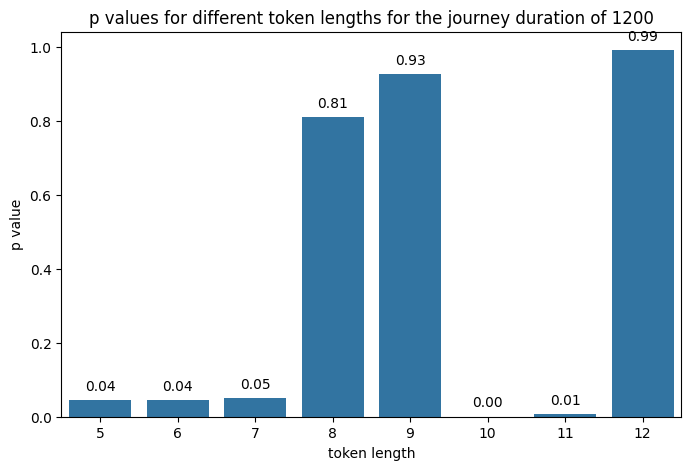

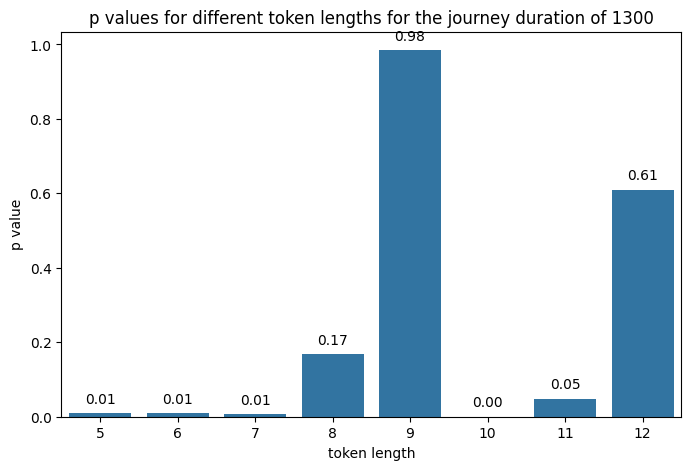

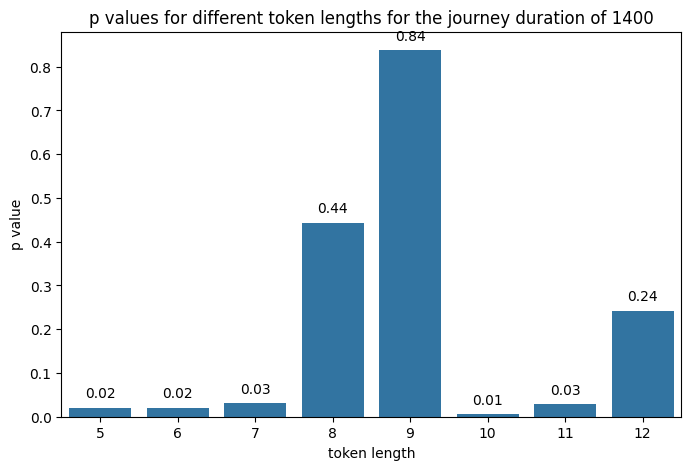

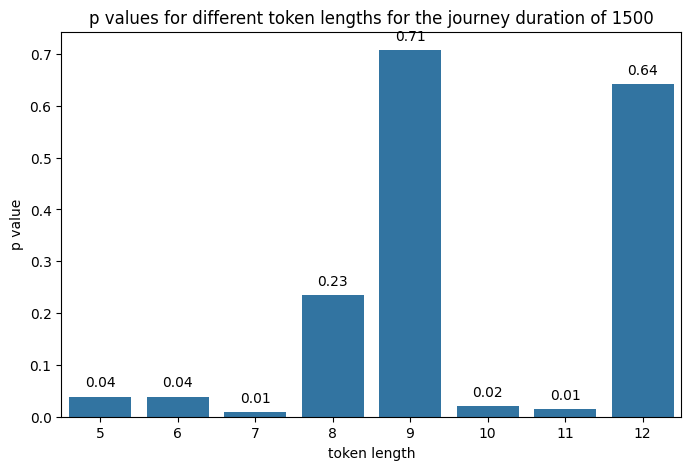

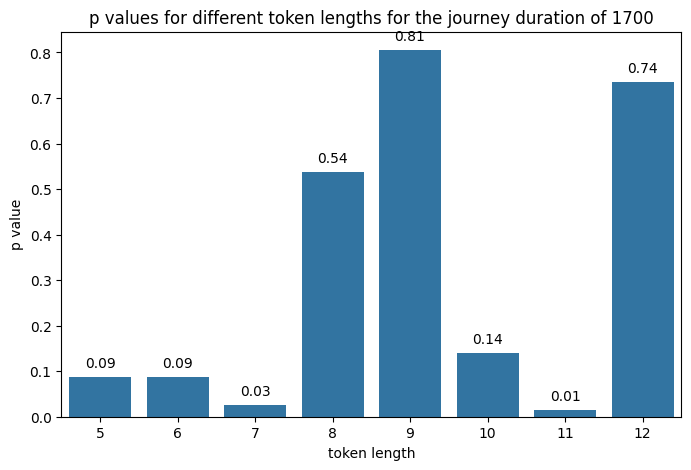

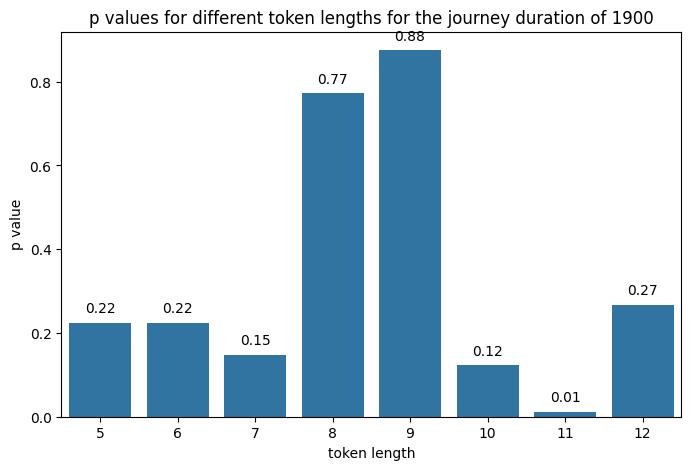

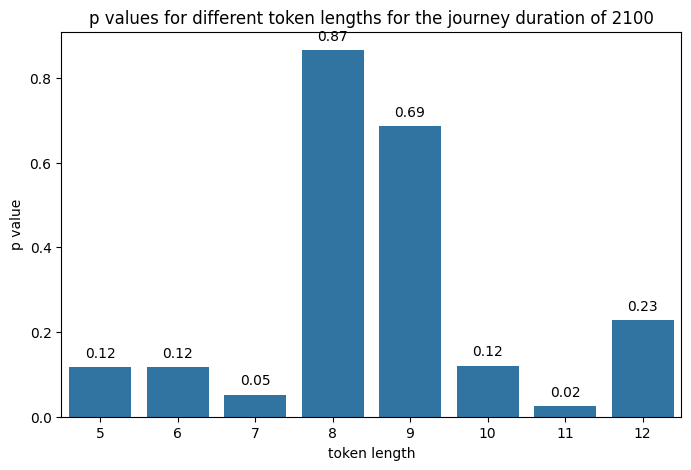

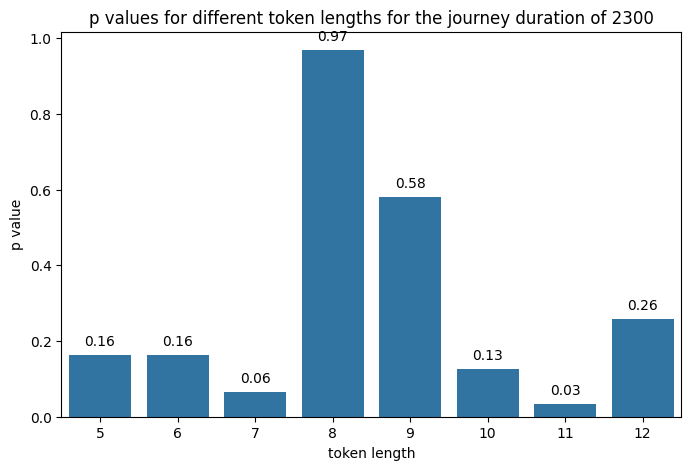

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns


for duration in list(range(30, 150, 30)) + list(range(150, 500, 50)) + list(range(500, 1500, 100)) + list(range(1500, 2500, 200)):
    f, ax = plt.subplots(1, 1, figsize=(8, 5))

    sns.barplot(plotDf[plotDf['journey duration'] == duration], x='token length', y='p value',  ax=ax)

    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    
    ax.set_title('p values for different token lengths for the journey duration of ' + str(duration))

    plt.show()

### Combined heatmap

In [14]:
heatmapDf = plotDf.pivot_table(index='token length',columns='journey duration', values='p value', aggfunc='mean')
heatmapDf

journey duration,30,60,90,120,150,200,250,300,350,400,...,1000,1100,1200,1300,1400,1500,1700,1900,2100,2300
token length,,,,,,,,,,,,,,,,,,,,,
5,1.668526e-02,0.000297,0.000023,1.468774e-07,7.321588e-01,0.608484,0.440492,0.210844,0.116029,0.080115,...,0.001401,0.006523,0.044388,0.009274,0.020503,0.038634,0.086187,0.224424,0.116471,0.162845
6,1.668526e-02,0.000297,0.000023,1.468774e-07,7.321588e-01,0.608484,0.440492,0.210844,0.116029,0.080115,...,0.001401,0.006523,0.044388,0.009274,0.020503,0.038634,0.086187,0.224424,0.116471,0.162845
7,4.431000e-05,0.000041,0.000070,1.592977e-04,2.812633e-06,0.079942,0.603909,0.000005,0.092527,0.335934,...,0.005610,0.002799,0.050133,0.007588,0.031044,0.008437,0.025566,0.148168,0.051862,0.064487
8,4.431000e-05,0.183831,0.283768,2.165248e-08,3.088164e-08,0.043057,0.763590,0.000164,0.433327,0.340925,...,0.164986,0.139253,0.809608,0.168968,0.443345,0.234326,0.537240,0.771812,0.865606,0.968653
9,8.583746e-10,0.079478,0.532664,2.593892e-10,1.784451e-09,0.000579,0.360425,0.000006,0.003186,0.000005,...,0.181559,0.995864,0.925560,0.984790,0.837894,0.707508,0.805331,0.875348,0.686299,0.580503
10,1.375849e-01,0.059912,0.322794,1.185438e-02,5.569103e-03,0.109098,0.838810,0.006753,0.606247,0.150623,...,0.005876,0.005616,0.000404,0.000326,0.006255,0.020812,0.140314,0.123376,0.120493,0.125009
11,5.956082e-02,0.493741,0.816858,7.447394e-03,1.840857e-02,0.131051,0.032032,0.632818,0.529608,0.579524,...,0.000228,0.001004,0.007180,0.048455,0.028593,0.014857,0.013918,0.011991,0.024875,0.033806
12,1.935694e-02,0.002771,0.078216,9.722514e-02,3.322884e-01,0.207946,0.382470,0.254242,0.550639,0.822550,...,0.041744,0.771729,0.990439,0.610233,0.242587,0.641248,0.735207,0.267675,0.227191,0.257553


[Text(0.5, 25.722222222222214, 'Duration'),
 Text(158.22222222222223, 0.5, 'Minimum token length')]

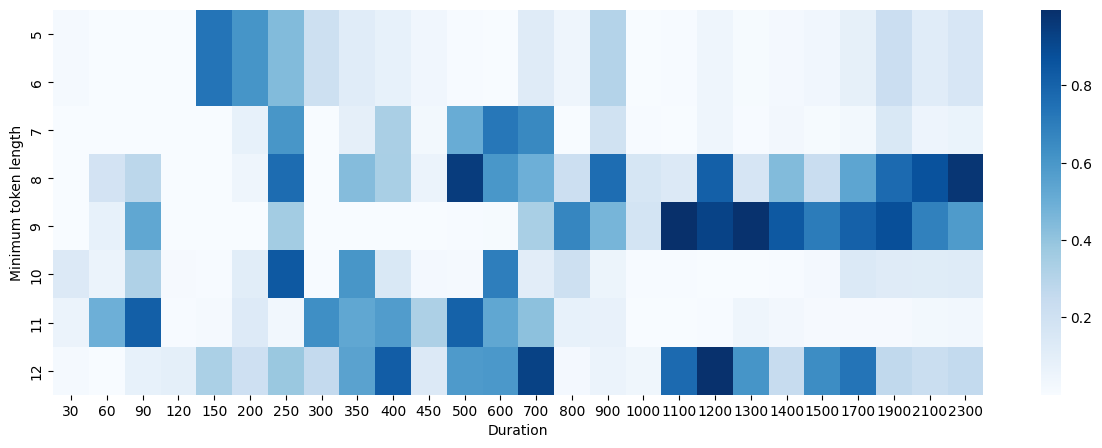

In [21]:
import seaborn as sns

f, ax = plt.subplots(1, 1, figsize=(15, 5))

ax = sns.heatmap(
    heatmapDf,
    # annot=True,
    # fmt=".2f",
    cmap="Blues",
    # vmin=0.6,
    # vmax=0.9,
    # yticklabels=['0', '1', '2'],
    # xticklabels=['1', '2', '3', '4', '5', '6'],
    
)
ax.set(xlabel='Duration', ylabel='Minimum token length')

[Text(0.5, 25.722222222222214, 'Duration'),
 Text(158.22222222222223, 0.5, 'Minimum token length')]

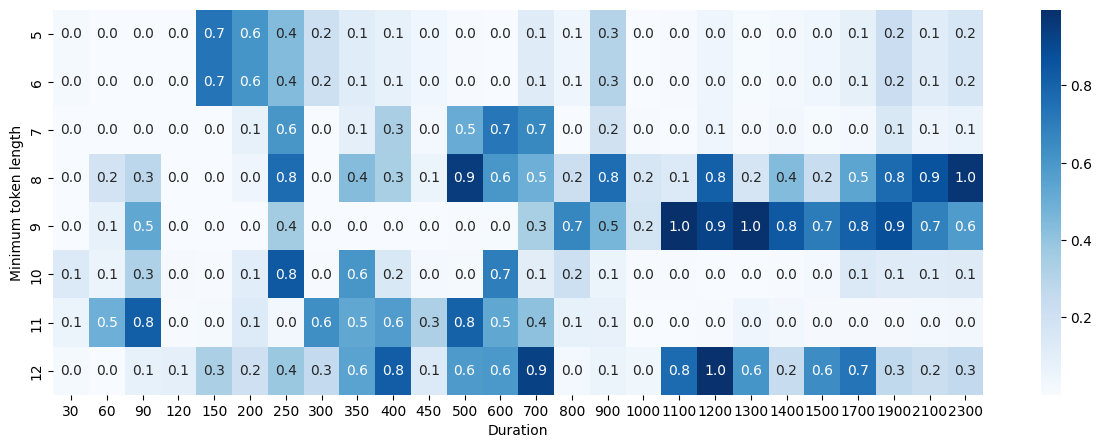

In [20]:
import seaborn as sns

f, ax = plt.subplots(1, 1, figsize=(15, 5))

ax = sns.heatmap(
    heatmapDf,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    # vmin=0.6,
    # vmax=0.9,
    # yticklabels=['0', '1', '2'],
    # xticklabels=['1', '2', '3', '4', '5', '6'],
    
)
ax.set(xlabel='Duration', ylabel='Minimum token length')

In [29]:
plotDf['significant'] = plotDf['p value'] > 0.05
heatmapDf = plotDf.pivot_table(index='token length',columns='journey duration', values='significant')
heatmapDf

journey duration,30,60,90,120,150,200,250,300,350,400,...,1000,1100,1200,1300,1400,1500,1700,1900,2100,2300
token length,,,,,,,,,,,,,,,,,,,,,
5,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
6,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
7,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
8,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
10,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
11,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


[Text(0.5, 25.722222222222214, 'Duration'),
 Text(158.22222222222223, 0.5, 'Significant')]

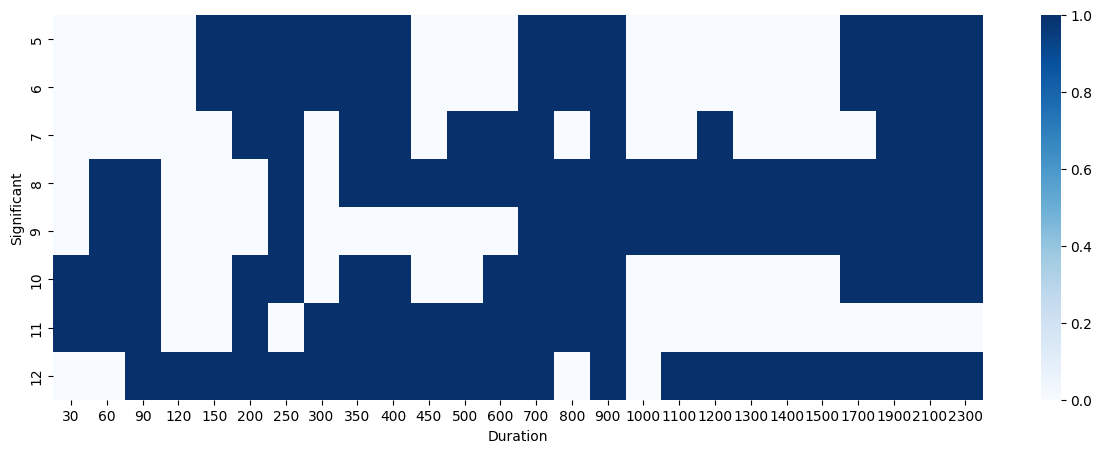

In [31]:
import seaborn as sns

f, ax = plt.subplots(1, 1, figsize=(15, 5))

ax = sns.heatmap(
    heatmapDf,
    # annot=True,
    # fmt=".1f",
    cmap="Blues",
    # vmin=0.6,
    # vmax=0.9,
    # yticklabels=['0', '1', '2'],
    # xticklabels=['1', '2', '3', '4', '5', '6'],
    
)
ax.set(xlabel='Duration', ylabel='Significant')